## **Objective**
Given historical data of Buildings A and B, predict the Buildings' future Cooling Loads.

## **Data Analysis**

A quick scan through of the 2 given datasets revealed that Building A had **significantly more data** than Building B **(10,000 vs 1,000 rows)**. Hence, we'll be focusing on Building A, and transfer outcome to Building B.

Initial data analysis using `plotly` for interactive dashboards to help understand data better.

**Reference - `plot.py`**

In [15]:
# @title
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash import dcc, html
from dash.dependencies import Input, Output
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from jupyter_dash import JupyterDash


df = pd.read_csv('resources/Building_A_summary_table.csv') #USER INPUT FILE.
#Data preparation
df['record_timestamp'] = pd.to_datetime(df['record_timestamp'], format='%d/%m/%Y %H:%M')

# Initialize Dash app
app = JupyterDash(__name__)
app.title = "Chiller analysis Dashboard"

# Define chiller names and parameters
chillers = ['CHR-01', 'CHR-02', 'CHR-03', 'CHR-04']
parameters = ['CHWSWT', 'CHWRWT', 'CHWFWR', 'KW', 'Q']
param_names = {
    'CHWSWT': 'Chilled Water Supply Temperature (°C)',
    'CHWRWT': 'Chilled Water Return Temperature (°C)',
    'CHWFWR': 'Chilled Water Flow Rate (L/s)',
    'KW': 'Power Consumption (kW)',
    'Q': 'Cooling Capacity (kW)'
}
# Get all available column names for dropdowns
all_columns = [col for col in df.columns if col != 'record_timestamp']

# App layout
app.layout = html.Div([
    html.H1("Chiller analysis Dashboard",
            style={'textAlign': 'center', 'color': '#2c3e50'}),

    html.Div([
        html.Div([
            html.Label("Select Chiller:"),
            dcc.Dropdown(
                id='chiller-dropdown',
                options=[{'label': chiller, 'value': chiller} for chiller in chillers],
                value='CHR-01',
                clearable=False
            )
        ], style={'width': '30%', 'display': 'inline-block', 'padding': '10px'}),

        html.Div([
            html.Label("Select Parameter:"),
            dcc.Dropdown(
                id='parameter-dropdown',
                options=[{'label': param_names[param], 'value': param} for param in parameters],
                value='CHWSWT',
                clearable=False
            )
        ], style={'width': '30%', 'display': 'inline-block', 'padding': '10px'}),

        html.Div([
            html.Label("Date Range:"),
            dcc.DatePickerRange(
                id='date-picker',
                start_date=df['record_timestamp'].min(),
                end_date=df['record_timestamp'].max(),
                display_format='YYYY-MM-DD'
            )
        ], style={'width': '40%', 'display': 'inline-block', 'padding': '10px'})
    ]),

    dcc.Graph(id='time-series-plot'),

    html.Div([
        html.Div([
            html.H3("Summary Statistics", style={'textAlign': 'center'}),
            html.Div(id='summary-stats')
        ], style={'width': '30%', 'display': 'inline-block', 'verticalAlign': 'top'}),

        html.Div([
            dcc.Graph(id='comparison-plot')
        ], style={'width': '70%', 'display': 'inline-block'})
    ]),

    # NEW: Dual Parameter Comparison Section
    html.Hr(),
    html.H2("Dual Parameter Comparison (Normalized)",
            style={'textAlign': 'center', 'color': '#2c3e50', 'marginTop': '30px'}),

    html.Div([
        html.Div([
            html.Label("Select First Parameter:"),
            dcc.Dropdown(
                id='param1-dropdown',
                options=[{'label': col, 'value': col} for col in all_columns],
                value='CHR-01-CHWSWT',
                clearable=False
            )
        ], style={'width': '30%', 'display': 'inline-block', 'padding': '10px'}),

        html.Div([
            html.Label("Select Second Parameter:"),
            dcc.Dropdown(
                id='param2-dropdown',
                options=[{'label': col, 'value': col} for col in all_columns],
                value='CHR-01-CHWRWT',
                clearable=False
            )
        ], style={'width': '30%', 'display': 'inline-block', 'padding': '10px'}),

        html.Div([
            html.Label("Normalization Method:"),
            dcc.RadioItems(
                id='normalization-method',
                options=[
                    {'label': 'Min-Max Scaling (0-1)', 'value': 'minmax'},
                    {'label': 'Z-Score Standardization', 'value': 'zscore'},
                    {'label': 'No Normalization', 'value': 'none'}
                ],
                value='minmax',
                inline=True
            )
        ], style={'width': '40%', 'display': 'inline-block', 'padding': '10px'})
    ]),

    dcc.Graph(id='dual-parameter-plot'),

    html.Div([
        html.Div([
            html.H4("Correlation Analysis", style={'textAlign': 'center'}),
            html.Div(id='correlation-stats')
        ], style={'width': '30%', 'display': 'inline-block', 'verticalAlign': 'top'}),

        html.Div([
            dcc.Graph(id='scatter-plot')
        ], style={'width': '70%', 'display': 'inline-block'})
    ]),

    dcc.Graph(id='correlation-heatmap'),

    # NEW: Plot of selected column against time
    html.Hr(),
    html.H2("Plot of selected column against time",
            style={'textAlign': 'center', 'color': '#2c3e50', 'marginTop': '30px'}),
    html.Div([
        html.Div([
            html.Label("Select Column:"),
            dcc.Dropdown(
                id='single-column-dropdown',
                options=[{'label': col, 'value': col} for col in all_columns],
                value=all_columns[0],
                clearable=False
            )
        ], style={'width': '30%', 'display': 'inline-block', 'padding': '10px'}),
        html.Div([
            html.Label("Normalization Method:"),
            dcc.RadioItems(
                id='single-column-normalization',
                options=[
                    {'label': 'Min-Max Scaling (0-1)', 'value': 'minmax'},
                    {'label': 'Z-Score Standardization', 'value': 'zscore'},
                    {'label': 'No Normalization', 'value': 'none'}
                ],
                value='none',
                inline=True
            )
        ], style={'width': '40%', 'display': 'inline-block', 'padding': '10px'})
    ]),
    dcc.Graph(id='single-column-plot'),

    dcc.Interval(
        id='interval-component',
        interval=60*1000,
        n_intervals=0
    )
], style={'padding': '20px'})

# Normalization functions
def normalize_data(data, method='minmax'):
    if method == 'minmax':
        scaler = MinMaxScaler()
        return scaler.fit_transform(data.values.reshape(-1, 1)).flatten()
    elif method == 'zscore':
        return (data - data.mean()) / data.std()
    else:  # no normalization
        return data

# Callbacks
@app.callback(
    [Output('time-series-plot', 'figure'),
     Output('summary-stats', 'children'),
     Output('comparison-plot', 'figure'),
     Output('dual-parameter-plot', 'figure'),
     Output('scatter-plot', 'figure'),
     Output('correlation-stats', 'children'),
     Output('correlation-heatmap', 'figure'),
     Output('single-column-plot', 'figure')],
    [Input('chiller-dropdown', 'value'),
     Input('parameter-dropdown', 'value'),
     Input('date-picker', 'start_date'),
     Input('date-picker', 'end_date'),
     Input('param1-dropdown', 'value'),
     Input('param2-dropdown', 'value'),
     Input('normalization-method', 'value'),
     Input('single-column-dropdown', 'value'),
     Input('single-column-normalization', 'value'),
     Input('interval-component', 'n_intervals')]
)
def update_dashboard(selected_chiller, selected_param, start_date, end_date,
                    param1, param2, norm_method, selected_column, single_col_norm_method, n):
    # Filter data based on date range
    filtered_df = df[(df['record_timestamp'] >= start_date) &
                    (df['record_timestamp'] <= end_date)].copy()

    # Time Series Plot
    col_name = f"{selected_chiller}-{selected_param}"
    ts_fig = px.line(filtered_df, x='record_timestamp', y=col_name,
                    title=f'{selected_chiller} - {param_names[selected_param]} Over Time')
    ts_fig.update_layout(
        xaxis_title='Time',
        yaxis_title=param_names[selected_param],
        hovermode='x unified'
    )

    # Summary Statistics
    current_data = filtered_df[col_name]
    stats = [
        html.P(f"Current Value: {current_data.iloc[-1]:.2f}"),
        html.P(f"Average: {current_data.mean():.2f}"),
        html.P(f"Minimum: {current_data.min():.2f}"),
        html.P(f"Maximum: {current_data.max():.2f}"),
        html.P(f"Standard Deviation: {current_data.std():.2f}")
    ]

    # Comparison Plot
    comp_fig = go.Figure()
    for chiller in chillers:
        comp_col = f"{chiller}-{selected_param}"
        comp_fig.add_trace(go.Scatter(
            x=filtered_df['record_timestamp'],
            y=filtered_df[comp_col],
            name=chiller,
            mode='lines'
        ))

    comp_fig.update_layout(
        title=f'Comparison: {param_names[selected_param]} Across All Chillers',
        xaxis_title='Time',
        yaxis_title=param_names[selected_param],
        hovermode='x unified'
    )

    # NEW: Dual Parameter Plot with Normalization
    if param1 in filtered_df.columns and param2 in filtered_df.columns:
        # Normalize data
        param1_norm = normalize_data(filtered_df[param1], norm_method)
        param2_norm = normalize_data(filtered_df[param2], norm_method)

        dual_fig = go.Figure()
        dual_fig.add_trace(go.Scatter(
            x=filtered_df['record_timestamp'],
            y=param1_norm,
            name=param1,
            mode='lines',
            line=dict(color='blue')
        ))
        dual_fig.add_trace(go.Scatter(
            x=filtered_df['record_timestamp'],
            y=param2_norm,
            name=param2,
            mode='lines',
            line=dict(color='red')
        ))

        norm_label = "Normalized Value" if norm_method != 'none' else "Original Value"
        dual_fig.update_layout(
            title=f'Dual Parameter Comparison: {param1} vs {param2}',
            xaxis_title='Time',
            yaxis_title=norm_label,
            hovermode='x unified',
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
        )

        # Scatter Plot
        scatter_fig = px.scatter(
            x=filtered_df[param1],
            y=filtered_df[param2],
            title=f'Scatter Plot: {param1} vs {param2}',
            labels={'x': param1, 'y': param2}
        )
        scatter_fig.update_traces(marker=dict(size=8, opacity=0.6))

        # Correlation Statistics
        correlation = filtered_df[param1].corr(filtered_df[param2])
        corr_stats = [
            html.H5(f"Correlation Analysis"),
            html.P(f"Correlation Coefficient: {correlation:.3f}"),
            html.P(f"Sample Size: {len(filtered_df)} points"),
            html.P(f"Parameter 1 Mean: {filtered_df[param1].mean():.2f}"),
            html.P(f"Parameter 2 Mean: {filtered_df[param2].mean():.2f}"),
            html.P(f"Parameter 1 Std: {filtered_df[param1].std():.2f}"),
            html.P(f"Parameter 2 Std: {filtered_df[param2].std():.2f}")
        ]

    else:
        dual_fig = go.Figure()
        scatter_fig = go.Figure()
        corr_stats = [html.P("Selected parameters not available in filtered data")]

    # Correlation Heatmap
    numeric_cols = [col for col in df.columns if col != 'record_timestamp' and col != 'season']
    corr_data = filtered_df[numeric_cols].corr()

    heat_fig = px.imshow(corr_data,
                        title='Correlation Heatmap Between All Parameters',
                        aspect='auto',
                        color_continuous_scale='RdBu_r')
    heat_fig.update_layout(height=600)

    # NEW: Single Column Plot
    y_data = normalize_data(filtered_df[selected_column], single_col_norm_method)
    y_axis_label = "Normalized Value" if single_col_norm_method != 'none' else selected_column

    single_col_fig = go.Figure()
    single_col_fig.add_trace(go.Scatter(
        x=filtered_df['record_timestamp'],
        y=y_data,
        name=selected_column,
        mode='lines'
    ))
    single_col_fig.update_layout(
        title=f'Plot of {selected_column} Over Time',
        xaxis_title='Time',
        yaxis_title=y_axis_label,
        hovermode='x unified'
    )

    return ts_fig, stats, comp_fig, dual_fig, scatter_fig, corr_stats, heat_fig, single_col_fig

if __name__ == '__main__':
    app.run(debug=True, port=8050)

c:\Users\User\source\repos\rt-model\venv\Lib\site-packages\dash\dash.py:634: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



## **Model Algorithm**

From the analysis of given data and information from the brief, I understood the goal was to predict the buildings' total cooling load, a continuous value, given historical labelled data. Hence, this task is primarily a supervised learning, regression problem.

There were a few algorithms that came to mind to tackle a regression problem :
- Linear regression
- Support Vector Machines (SVM)
- Random Forest
- Gradient Boosting Machines (GBM)
- Neural Networks

I've decided on **Random Forest** and **Gradient Boosting Machines (GBM)**, with the following considerations:
1. Excellent for tabular data
2. Fast to train
3. Able to capture complex non-linear relationships (e.g., load vs. temp is not linear)
4. Natively handle multiple features (weather, time, holidays).

##### **Considerations for other algorithms**

While other algorithms might be suitable to tackle the task at hand, I wanted to limit the scope, and focus on demonstrating my ability to problem solve instead. Hence, I did not explore the use of other algorithms like SVMs and Neural Networks, that may require more extensive data preprocessing, i.e. scaling and normalization. That said, given more time on this task, building Neural Network model is definitely a worthy pursuit.

## **First Instinct**

My first instinct was, **"What's the fastest way to get my first set of predictions ?"** Through my years building software, I've learnt that the best way to validate an outcome was to put it in the hands of the user. **Build, review, iterate, repeat.**

And I think that applies here as well, build model, review model, iterate.

I was hyperfocused on filling up `Result.csv`.

In [2]:
# @title
df =  pd.read_csv('resources/Result.csv')
df.head()

,building_id,prediction_time,predicted_load
0,BuildingA_1,1/1/2025 0:00,NaN
1,BuildingA_2,1/1/2025 1:00,NaN
2,BuildingA_3,1/1/2025 2:00,NaN
3,BuildingA_4,1/1/2025 3:00,NaN
4,BuildingA_5,1/1/2025 4:00,NaN


The only way forward with 1 usable data column, i.e. `prediction_time` a datetime field, was to morph it into other usable parameters. Hence, I started with `hour_of_day`, `day_of_week`, `month`, `is_weekend` for my first test set.

**Reference - `z_attempt1/testing.py`**

In [3]:
# @title First test dataset
df =  pd.read_csv('resources/Result.csv')

def create_time_features(df, timestamp_col):
    """
    Create basic time-based features from timestamp
    """
    df = df.copy()

    # Convert to datetime
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], format='%d/%m/%Y %H:%M')

    # Extract features
    df['hour_of_day'] = df[timestamp_col].dt.hour
    df['day_of_week'] = df[timestamp_col].dt.dayofweek  # 0=Monday, 6=Sunday
    df['month'] = df[timestamp_col].dt.month
    df['is_weekend'] = (df[timestamp_col].dt.dayofweek >= 5).astype(int)

    return df

df = create_time_features(df, 'prediction_time')
df.head()

,building_id,prediction_time,predicted_load,hour_of_day,day_of_week,month,is_weekend
0,BuildingA_1,2025-01-01 00:00:00,NaN,0,2,1,0
1,BuildingA_2,2025-01-01 01:00:00,NaN,1,2,1,0
2,BuildingA_3,2025-01-01 02:00:00,NaN,2,2,1,0
3,BuildingA_4,2025-01-01 03:00:00,NaN,3,2,1,0
4,BuildingA_5,2025-01-01 04:00:00,NaN,4,2,1,0


Naturally, this influenced my training data.

Along with formulas given on the brief, I was able to compute `Total Cooling Load` for my first training data set.

**Reference - `z_attempt1/data_preparation.py`**

In [4]:
def create_time_features(df, timestamp_col):
    """
    Create basic time-based features from timestamp
    """
    df = df.copy()
    # Convert to datetime
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], format='%d/%m/%Y %H:%M')
    # Extract features
    df['hour_of_day'] = df[timestamp_col].dt.hour
    df['day_of_week'] = df[timestamp_col].dt.dayofweek  # 0=Monday, 6=Sunday
    df['month'] = df[timestamp_col].dt.month
    df['is_weekend'] = (df[timestamp_col].dt.dayofweek >= 5).astype(int)
    return df

df = pd.read_csv('resources/Building_A_summary_table.csv')
#Data preparation
# 1 watt = 1 joule/second
# Cp = 4.19 kJ/kg.C
# Calculate cooling capacity Q (kW) = m (l/s) * Cp (kJ/kg.C) * ΔT (C)
df['CHR-01-Q'] = df['CHR-01-CHWFWR'] * (df['CHR-01-CHWRWT'] - df['CHR-01-CHWSWT']) * 4.19
df['CHR-02-Q'] = df['CHR-02-CHWFWR'] * (df['CHR-02-CHWRWT'] - df['CHR-02-CHWSWT']) * 4.19
df['CHR-03-Q'] = df['CHR-03-CHWFWR'] * (df['CHR-03-CHWRWT'] - df['CHR-03-CHWSWT']) * 4.19
df['CHR-04-Q'] = df['CHR-04-CHWFWR'] * (df['CHR-04-CHWRWT'] - df['CHR-04-CHWSWT']) * 4.19

# Total cooling load
df['Total_Cooling_Load'] = df['CHR-01-Q'] + df['CHR-02-Q'] + df['CHR-03-Q'] + df['CHR-04-Q']
# Total power consumption
df['Total_Power_Consumption'] = df['CHR-01-KW'] + df['CHR-02-KW'] + df['CHR-03-KW'] + df['CHR-04-KW']
# COP
df['Total_COP'] = df['Total_Cooling_Load'] / df['Total_Power_Consumption']

#clean NaN
df.dropna(inplace=True)
df = create_time_features( df, 'record_timestamp')
df = df[['record_timestamp', 'Total_Cooling_Load','hour_of_day', 'day_of_week', 'month', 'is_weekend']]
df.head()

,record_timestamp,Total_Cooling_Load,hour_of_day,day_of_week,month,is_weekend
0,2024-01-01 00:00:00,0.0,0,0,1,0
1,2024-01-01 00:15:00,0.0,0,0,1,0
2,2024-01-01 00:30:00,0.0,0,0,1,0
3,2024-01-01 00:45:00,0.0,0,0,1,0
4,2024-01-01 01:00:00,0.0,1,0,1,0


Afterwhich, applied standard train-test split technique, to evaluate a model performance. I used a conservative  80%-20% split.

For the first run, I used `RandomForestRegressor` since it was out-of-the-box.

**Reference - `z_attempt1/training.py`**

In [5]:
# @title First training model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

target = 'Total_Cooling_Load'
features = ['hour_of_day', 'day_of_week', 'month', 'is_weekend']
print( features )

# Check if all required columns are present
required_columns = features + [target]
if not all(col in df.columns for col in required_columns):
    print(f"Error: Not all required columns are in the dataframe.")
    exit()

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 3: Train the Model ---
# Initialize and train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("Training the model...")
model.fit(X_train, y_train)
print("Model training complete.")

# --- Step 4: Evaluate the Model ---
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Model Mean Squared Error: {mse:.2f}")


['hour_of_day', 'day_of_week', 'month', 'is_weekend']
Training the model...
Model training complete.
Model Mean Squared Error: 389501.50


## **Fine-tuning**

This section will highlight some of the key insights when fine-tuning the model.

### **Changelog**
Table below shows the changelogs of all submission attempts.

| Attempt | Changelog | Features | Building(s) | NRMSE |
| ------------- |-------------|-------------|-------------|-------------|
| 1.| Feature engineer datetime | 'hour_of_day', 'day_of_week', 'month', 'is_weekend' | A | 0.272324029077967 |
| 2.| Remove rows where 'Total Cooling Load' is 0 kW |'hour_of_day', 'day_of_week', 'month', 'is_weekend' | A | 0.760444006251237 |
| 3.| Reinstate rows where 'Total Cooling Load' is 0 kW. Add 'season','day_of_month' features. | 'hour_of_day', 'day_of_week', 'month', 'is_weekend', 'season', 'day_of_month' | A | 0.27278177369591 |
| 4.| Replace Random Forest with XGBoost model | 'hour_of_day', 'day_of_week', 'month', 'is_weekend', 'season', 'day_of_month' | A | 0.24401739049425 |  
| 5.| Add features - 'humidity', 'temperature' | 'hour_of_day', 'day_of_week', 'month', 'is_weekend', 'season', 'day_of_month', 'humidity', 'temperature' | A | 0.26268367643862 |
| 6.| Remove features - 'day_of_week', 'month', 'day_of_month'| 'hour_of_day', 'is_weekend', 'season', 'humidity', 'temperature'  | A | 0.231354844346216 |
| 7.| Remove features - 'humidity', 'temperature'| 'hour_of_day', 'is_weekend', 'season'  | A | 0.170950607971046 |
| 8.| Add feature - 'is_business_hour', chiller off from 6pm-730am | 'hour_of_day', 'is_weekend', 'season', 'is_business_hour' | A | 0.17083490150497 |
| 9.| Add features - 'is_holiday' | 'hour_of_day', 'is_weekend', 'season', 'is_business_hour', 'is_holiday' | A | 0.156259368721473 |
| 10. | Reinstate 'temperature', 'humidity' & add weather features - 'solar' , 'temperature', 'humidity'| 'hour_of_day', 'is_weekend', 'season', 'is_business_hour', 'is_holiday','solar', 'temperature', 'humidity' | A | 0.216272799454793
| 11. | Early stopping to prevent overfitting | 'hour_of_day', 'is_weekend', 'season', 'is_business_hour', 'is_holiday','solar', 'temperature', 'humidity'| A | 0.20528351341103
| 12. | Add features - 'wind', 'rain'| 'hour_of_day', 'is_weekend', 'season', 'is_business_hour', 'is_holiday','solar', 'temperature', 'humidity', 'wind', 'rain' | A | 0.203494898452382
| 13. | Interpolate - 'humidity', 'temperature' due to 15m vs 1h intervals| 'hour_of_day', 'is_weekend', 'season', 'is_business_hour', 'is_holiday','solar', 'temperature', 'humidity', 'wind', 'rain'  | A | 0.2237978076295
| 14. | Tune model param - increase max depth | 'hour_of_day', 'is_weekend', 'season', 'is_business_hour', 'is_holiday','solar', 'temperature', 'humidity', 'wind', 'rain' | A | 0.229259198863011
| 15. | Discovered and fix interpolated data error from #13| 'hour_of_day', 'is_weekend', 'season', 'is_business_hour', 'is_holiday','solar', 'temperature', 'humidity', 'wind', 'rain'  | A | 0.208219339460784
| 16. | Prepare, train, test Building B dataset separately| 'hour_of_day', 'is_weekend', 'season', 'is_business_hour', 'is_holiday','solar', 'temperature', 'humidity', 'wind', 'rain'  | A & B | 0.2066380966636
| 17. | Remove booster from A | 'hour_of_day', 'is_weekend', 'season', 'is_business_hour', 'is_holiday','solar', 'temperature', 'humidity', 'wind', 'rain' | A & B | 0.203805870641031
| 18. | Reinstate booster. Attempt remove 'solar' due to high weightage, tune params to reduce overfitting| 'hour_of_day', 'is_weekend', 'season', 'is_business_hour', 'is_holiday', 'temperature', 'humidity', 'wind', 'rain'  | A & B | 0.213344195415542
| 19. | Debug model with importance chart. Remove 'solar', 'wind', 'rain', 'humidity' | 'hour_of_day', 'is_weekend', 'season', 'is_business_hour', 'is_holiday', 'temperature', 'humidity' | A & B | 0.21024732902238 | 
| 20. | Remove 'temperature'| 'hour_of_day', 'is_weekend', 'season', 'is_business_hour', 'is_holiday' | A & B | 0.15415837836889 |
| 21. | Combine 'is_weekend' and 'is_holiday' to 'is_workday' | 'hour_of_day', ''season', 'is_business_hour', 'is_workday' | A & B | 0.154422246696922
| 22. | Reinstate 'is_weekend' and 'is_holiday' since score reduced | 'hour_of_day', ''season', 'is_business_hour', 'is_workday','is_weekend', 'is_holiday' | A & B | 0.154172032606424 |
| 23. | Add feature 'temperature_lag_6' | 'hour_of_day', ''season', 'is_business_hour', 'is_workday','is_weekend', 'is_holiday', 'temperature_lag_6' | A & B | 0.218137795540367 |
| 24. | Set 'temperature_lag_6' = 0 when non-working day and hour | 'hour_of_day', ''season', 'is_business_hour', 'is_workday','is_weekend', 'is_holiday', 'temperature_lag_6' | A & B | 0.221157498389907 |
| Final| Model from attempt 22  | 'hour_of_day', 'season', 'is_business_hour', 'is_workday','is_weekend', 'is_holiday' | A & B | 0.154172032606424 |



#### Attempt 4 : Replace Random Forest with Gradient Boosting Machine(GBM) model - XGBoost



In [6]:
import xgboost as xgb

model = xgb.XGBRegressor(
    objective = 'reg:squarederror',  # For regression tasks
    n_estimators = 100,             # Number of boosting rounds (trees)
    learning_rate = 0.05,            # How quickly the model learns
    max_depth = 6,                   # Maximum depth of each tree
    subsample = 0.8,                 # Fraction of samples used per tree
    colsample_bytree = 0.8,          # Fraction of features used per tree
    reg_alpha = 1,                   # L1 regularization
    reg_lambda = 1,                  # L2 regularization
    random_state = 42
)

#### Attempt 5 : Add weather features - 'humidity', 'temperature'

There were a few weather stations in Hong Kong. In order to find the nearest to our target building, I plotted the [Weather Station Dataset](https://data.gov.hk/en-data/dataset/hk-dpo-datagovhk2-city-dashboard-weather-station/resource/84cdf712-e0b5-486b-9ed7-69c8be4b83bf) from data.gov.hk, and referencing a google search on **'hong kong government building'** yielded an educated guess to use data from **'Hong Kong Park'** weather station. However, some datasets, i.e. Solar radiation, wind speed, rainfall were only available on **'King's Park'** weather station.

Weather datasets referenced are summarised in table below.


| Dataset | Station | Source |
| ------------- |-------------|-------------|
| Temperature | Hong Kong Park | https://data.gov.hk/en-data/dataset/hk-hko-rss-current-weather-report |
| Humidity | Hong Kong Park | https://data.gov.hk/en-data/dataset/hk-hko-rss-current-weather-report |
| Solar Radiation | King's Park | https://data.gov.hk/en-data/dataset/hk-hko-rss-daily-global-solar-radiation |
| Wind speed | King's Park | https://data.gov.hk/en-data/dataset/hk-hko-rss-daily-mean-wind-speed |
| Solar Radiation | King's Park | https://data.gov.hk/en-data/dataset/hk-hko-rss-daily-total-rainfall |

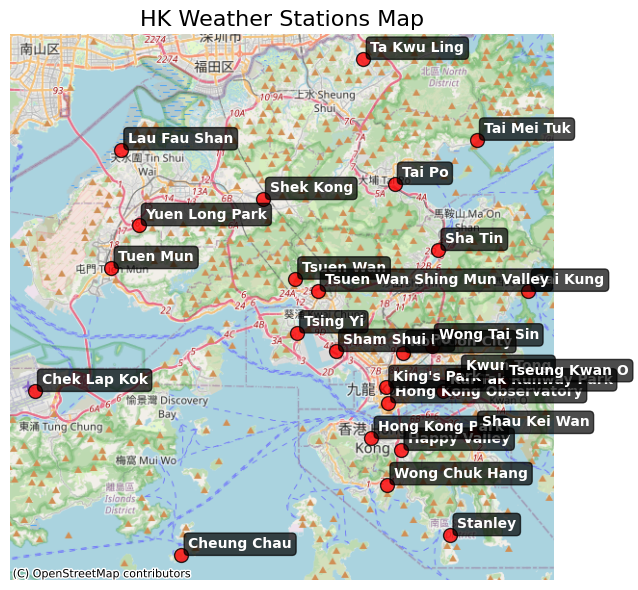

In [7]:
# @title HK Weather Station Locations
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
df =  pd.read_csv('weather//data//weather-station-info.csv')

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Convert to Web Mercator for background map
gdf_web_mercator = gdf.to_crs(epsg=3857)

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))
gdf_web_mercator.plot(ax=ax, color='red', markersize=100, alpha=0.8, edgecolor='black')

# Add background map
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add labels
for x, y, label in zip(gdf_web_mercator.geometry.x, gdf_web_mercator.geometry.y, gdf_web_mercator['station_name_en']):
    ax.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points",
                fontsize=10, fontweight='bold', color='white',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))

plt.title('HK Weather Stations Map', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

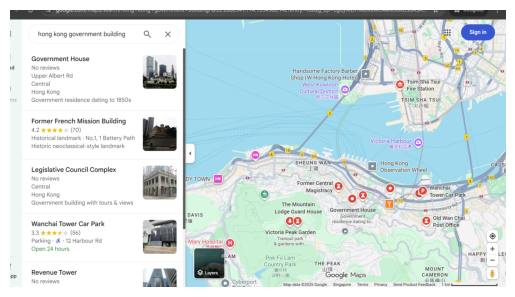

In [8]:
# @title HK Govt building Google search
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('images//hk-govt-building-gmap.png') #Replace "image.jpg" with the path of your image
plt.imshow(img)
plt.axis('off')
plt.show()

#### Attempts 6, 8, 9 : More meaningful datetime parameters

I revisited the existing datetime parameters, having background in HVAC systems, I knew that a building's Total Cooling load is driven by total occupancy.

**Hypothesis** : Cooling load is affected by occupancy.
- Does it matter whether it is a Monday or Friday ? Or only weekend or weekday.
- Does month matter  ? Or just affected by seasons.
- Does which day (1-30) matter ?

I wanted to test the hypothesis by removing - **'day_of_week', 'month', 'day_of_month'**.

This improved the NRMSE score ( ⬇ 0.03 ).

I went ahead to double down on what worked, which was to engineer more meaningful datetime features. 

With the help of the dashboards, I was able to identify daily chiller **operating hours (730am-6pm).** Adding `is_business_hour` to the list of features.

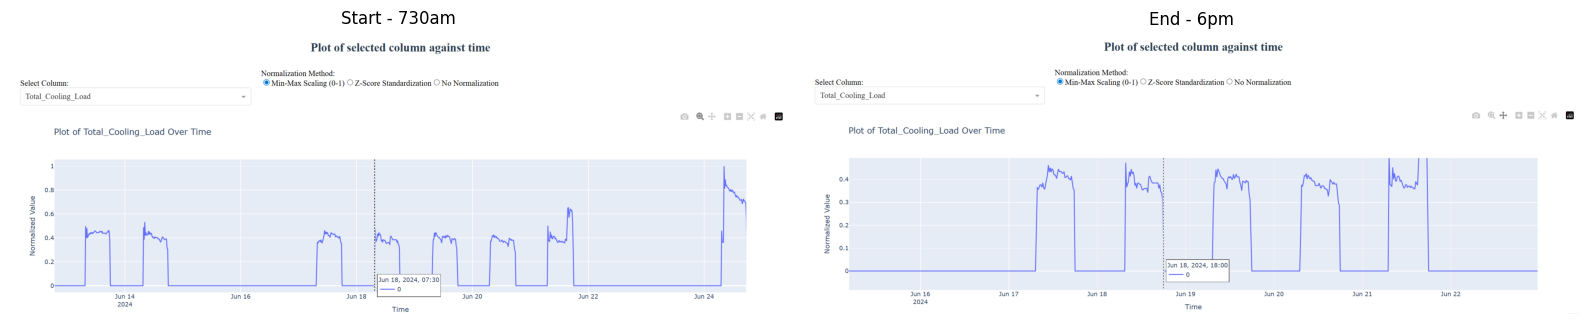

In [9]:
#@title Attempt 8 : 'is_business_hour', chiller off from 6pm-730am.
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
# Create sample images or load your own
image1 = mpimg.imread('images\\bizhr-1.png')  # Replace with your first image
image2 = mpimg.imread('images\\bizhr-2.png')  # Replace with your second image

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Display first image
axes[0].imshow(image1, cmap='gray')
axes[0].set_title('Start - 730am')
axes[0].axis('off')  # Remove axes

# Display second image
axes[1].imshow(image2, cmap='gray')
axes[1].set_title('End - 6pm')
axes[1].axis('off')  # Remove axes

plt.tight_layout()
plt.show()

Analysis revealed that `is_weekend` is highly related to `Total Cooling Load`.

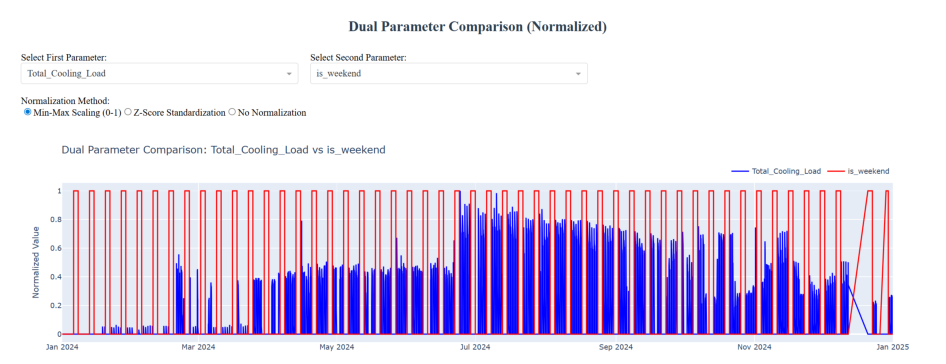

In [10]:
# @title Total Cooling Load Vs is_weekend
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=80)
img = mpimg.imread('images//wkend-vs-q.png') #Replace "image.jpg" with the path of your image
plt.imshow(img)
plt.axis('off')
plt.show()

Hence, I wanted to fill up gaps on public holidays using [HK holidays dataset](https://data.gov.hk/en-data/dataset/hk-dpo-statistic-cal), `is_holiday` was introduced as a new feature. 

This improved the NRMSE score from 0.1708 to 0.1562 ( ⬇ 0.0146 ).

## Attempts 10 ~ 15 : Weather data

Below is a summary of weather data used along with their intervals

| Dataset | Intervals |
| ------------- |-------------|
| Temperature | Hourly | 
| Humidity | Hourly |
| Solar Radiation | Daily|
| Wind speed | Daily|
| Solar Radiation | Daily|

As evident from the changelog table, weather data did not improve the model NRMSE scores. Hence, attempts 10 thru 15, were a mixed of attempts to figure out a way to make good use of the weather data. After a number of attempts and research, the problem appears be the model **overfitting**.

This included :
- Interpolation of 'temperature' and 'humidity' to 15min intervals to match dataset
- Set early stopping to prevent overfitting
- Tune model parameters

**Reference - `z_attempt15//training.py`**

In [11]:
# @title Big gap between train & validation error 
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
# --- Step 1: Load and Prepare Data ---
# Load the data from the CSV file.
try:
    df = pd.read_csv('z_attempt15//Building_A.csv')
except FileNotFoundError:
    print("Error: Building_A.csv not found in folder.")
    exit()

# --- Step 2: Feature Selection and Data Splitting ---
target = 'Total_Cooling_Load'

# One-hot encode the 'season' column
df = pd.get_dummies(df, columns=['season'])
season_columns = [col for col in df.columns if col.startswith('season_')]

features = ['hour_of_day', 'is_weekend', 'is_business_hour','is_holiday','temperature','humidity','solar', 'rain', 'wind']
features = features + season_columns
# Check if all required columns are present
required_columns = features + [target]
if not all(col in df.columns for col in required_columns):
    print(f"Error: Not all required columns are in the dataframe.")
    exit()

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

evals = [(dtrain, 'train'), (dval, 'val')]
# --- Step 3: Train the Model ---

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 4,           # Much shallower trees
    'learning_rate': 0.05,    # Moderate learning rate
    'subsample': 0.8,         # Randomly sample 80% of data for each tree
    'colsample_bytree': 0.8,  # Randomly sample 80% of features for each tree
    'reg_lambda': 1,          # L2 regularization
        # Let early stopping find the best number
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=10000,  # Set a very high number
    evals=evals,
    early_stopping_rounds=50, # Stop after 50 rounds without improvement on VALIDATION set
    verbose_eval=50
)

# fig, ax = plt.subplots(figsize=(10, 12))
# xgb.plot_importance(model, importance_type='weight', ax=ax) # 'weight' is the number of times a feature is used
# plt.show()

[0]	train-rmse:1462.98211	val-rmse:1465.56121
[50]	train-rmse:611.48699	val-rmse:623.00966
[100]	train-rmse:536.15411	val-rmse:553.34467
[150]	train-rmse:504.10229	val-rmse:525.69632
[200]	train-rmse:477.02486	val-rmse:503.62320
[250]	train-rmse:453.48396	val-rmse:483.31391
[300]	train-rmse:435.41147	val-rmse:467.88792
[350]	train-rmse:419.85947	val-rmse:454.04205
[400]	train-rmse:406.75928	val-rmse:442.62481
[450]	train-rmse:395.58635	val-rmse:433.36700
[500]	train-rmse:385.01093	val-rmse:424.76333
[550]	train-rmse:376.24175	val-rmse:417.91926
[600]	train-rmse:368.62325	val-rmse:411.82309
[650]	train-rmse:361.71813	val-rmse:406.42770
[700]	train-rmse:355.64077	val-rmse:401.55233
[750]	train-rmse:349.45929	val-rmse:396.71791
[800]	train-rmse:343.50753	val-rmse:392.58044
[850]	train-rmse:339.02996	val-rmse:389.33517
[900]	train-rmse:335.11169	val-rmse:386.59770
[950]	train-rmse:330.92955	val-rmse:383.66489
[1000]	train-rmse:327.51720	val-rmse:381.19008
[1050]	train-rmse:323.98262	val-rm

## Attempts 16 : Building B Transfer learning

XGBoost provides a simple utility to allow fine-tuning of model B from model A.

**Reference - `z_attempt16//training.py`**

In [12]:
# @title Building B transfer learning
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import os
# --- Step 1: Load and Prepare Data ---
# Load the data from the CSV file.
try:
    
    df = pd.read_csv('z_attempt16//Building_A.csv')
except FileNotFoundError:
    print("Error: Building_A.csv not found in folder.")
    exit()

# --- Step 2: Feature Selection and Data Splitting ---
# For this example, we'll focus on CHR-01
target = 'Total_Cooling_Load'

# One-hot encode the 'season' column
df = pd.get_dummies(df, columns=['season'])
season_columns = [col for col in df.columns if col.startswith('season_')]

features = ['hour_of_day', 'is_weekend', 'is_business_hour','is_holiday','temperature','humidity','solar', 'rain', 'wind']
features = features + season_columns

print( features )

# Check if all required columns are present
required_columns = features + [target]
if not all(col in df.columns for col in required_columns):
    print(f"Error: Not all required columns are in the dataframe.")
    exit()

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

evals = [(dtrain, 'train'), (dval, 'val')]
# --- Step 3: Train the Model ---

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 4,           # Much shallower trees
    'learning_rate': 0.01,    # Moderate learning rate
    'min_child_weight' : 5,
    'subsample': 0.8,         # Randomly sample 80% of data for each tree
    'colsample_bytree': 0.8,  # Randomly sample 80% of features for each tree
    'reg_alpha' : 1,
    'reg_lambda': 10,          # L2 regularizatioN
}

model_a = xgb.train(
    params,
    dtrain,
    num_boost_round=10000,  # Set a very high number
    evals=evals,
    early_stopping_rounds=50, # Stop after 50 rounds without improvement on VALIDATION set
    verbose_eval=50
)

#model b
try:
    df = pd.read_csv('z_attempt16//Building_B.csv')
except FileNotFoundError:
    print("Error: Building_B.csv not found in folder.")
    exit()

# --- Step 2: Feature Selection and Data Splitting ---
# For this example, we'll focus on CHR-01
target = 'Total_Cooling_Load'

# One-hot encode the 'season' column
df = pd.get_dummies(df, columns=['season'])
season_columns = [col for col in df.columns if col.startswith('season_')]

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

booster_building_a = model_a 
# 2. Prepare DMatrix for Building B's TRAINING data
dtrain_b = xgb.DMatrix(X_train, label=y_train)
# 3. Continue training (fine-tune)
# We use a very low learning rate to gently adjust the existing model.
fine_tune_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.01, # VERY LOW learning rate for fine-tuning
    'max_depth': 5, # Keep other parameters the same or adjust slightly
    'seed': 42
}

# Continue training for a limited number of rounds
model_b = xgb.train(
    fine_tune_params,
    dtrain_b,
    num_boost_round=100, 
    xgb_model=booster_building_a, 
    verbose_eval=10
)

['hour_of_day', 'is_weekend', 'is_business_hour', 'is_holiday', 'temperature', 'humidity', 'solar', 'rain', 'wind', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']
[0]	train-rmse:1509.62682	val-rmse:1513.04975
[50]	train-rmse:1116.07270	val-rmse:1116.88685
[100]	train-rmse:869.97287	val-rmse:874.78097
[150]	train-rmse:741.29492	val-rmse:750.28613
[200]	train-rmse:664.03512	val-rmse:676.17268
[250]	train-rmse:619.61527	val-rmse:633.51104
[300]	train-rmse:591.54383	val-rmse:606.33640
[350]	train-rmse:573.95403	val-rmse:589.67777
[400]	train-rmse:562.23155	val-rmse:578.92238
[450]	train-rmse:551.84974	val-rmse:569.07252
[500]	train-rmse:544.08360	val-rmse:561.94198
[550]	train-rmse:536.70648	val-rmse:555.12242
[600]	train-rmse:530.79396	val-rmse:549.71561
[650]	train-rmse:524.44798	val-rmse:544.14905
[700]	train-rmse:518.51843	val-rmse:538.66850
[750]	train-rmse:512.31466	val-rmse:533.38890
[800]	train-rmse:506.26086	val-rmse:528.26817
[850]	train-rmse:500.86449	val-rmse

## Attempts 18, 19, 20 

**Removing all weather features** on attempt 20 was a result of collective model debugging from attempts 18 & 19.

### Debugging Methodology

Plot importance charts. Here are the importance metrics as well as it's significance.
| Importance | Significance |
| ------------- |-------------|
| Weight | Number of times a feature is used to split the data across all trees | 
| Gain | Average training accuracy gain across all splits that use the feature  |
| Cover | Average number of data points affected by splits |

The aim is identify and remove features with **high weight/ cover, but low gain**. This is an indicator of overfitting caused by model latching onto noise. The feature might have found a correlation that will not produce good results in the test set.


**Reference - `z_attempt18//training.py`**

[0]	train-rmse:1509.62682	val-rmse:1513.04975
[50]	train-rmse:1116.03902	val-rmse:1116.85636
[100]	train-rmse:869.90377	val-rmse:874.70170
[150]	train-rmse:741.32965	val-rmse:750.26115
[200]	train-rmse:664.04465	val-rmse:676.15294
[250]	train-rmse:619.57297	val-rmse:633.30604
[300]	train-rmse:591.53514	val-rmse:606.12747
[350]	train-rmse:574.05869	val-rmse:589.93284
[400]	train-rmse:561.68577	val-rmse:578.41446
[450]	train-rmse:552.08851	val-rmse:569.31168
[500]	train-rmse:544.52906	val-rmse:562.37455
[550]	train-rmse:536.89678	val-rmse:555.29404
[600]	train-rmse:530.52797	val-rmse:549.42101
[650]	train-rmse:524.33991	val-rmse:543.91490
[700]	train-rmse:518.27283	val-rmse:538.58935
[750]	train-rmse:512.04935	val-rmse:533.18994
[800]	train-rmse:506.18824	val-rmse:528.14929
[850]	train-rmse:500.96474	val-rmse:523.68045
[900]	train-rmse:495.06588	val-rmse:518.68766
[950]	train-rmse:489.97257	val-rmse:514.42588
[1000]	train-rmse:484.85681	val-rmse:510.16104
[1050]	train-rmse:480.35244	val-

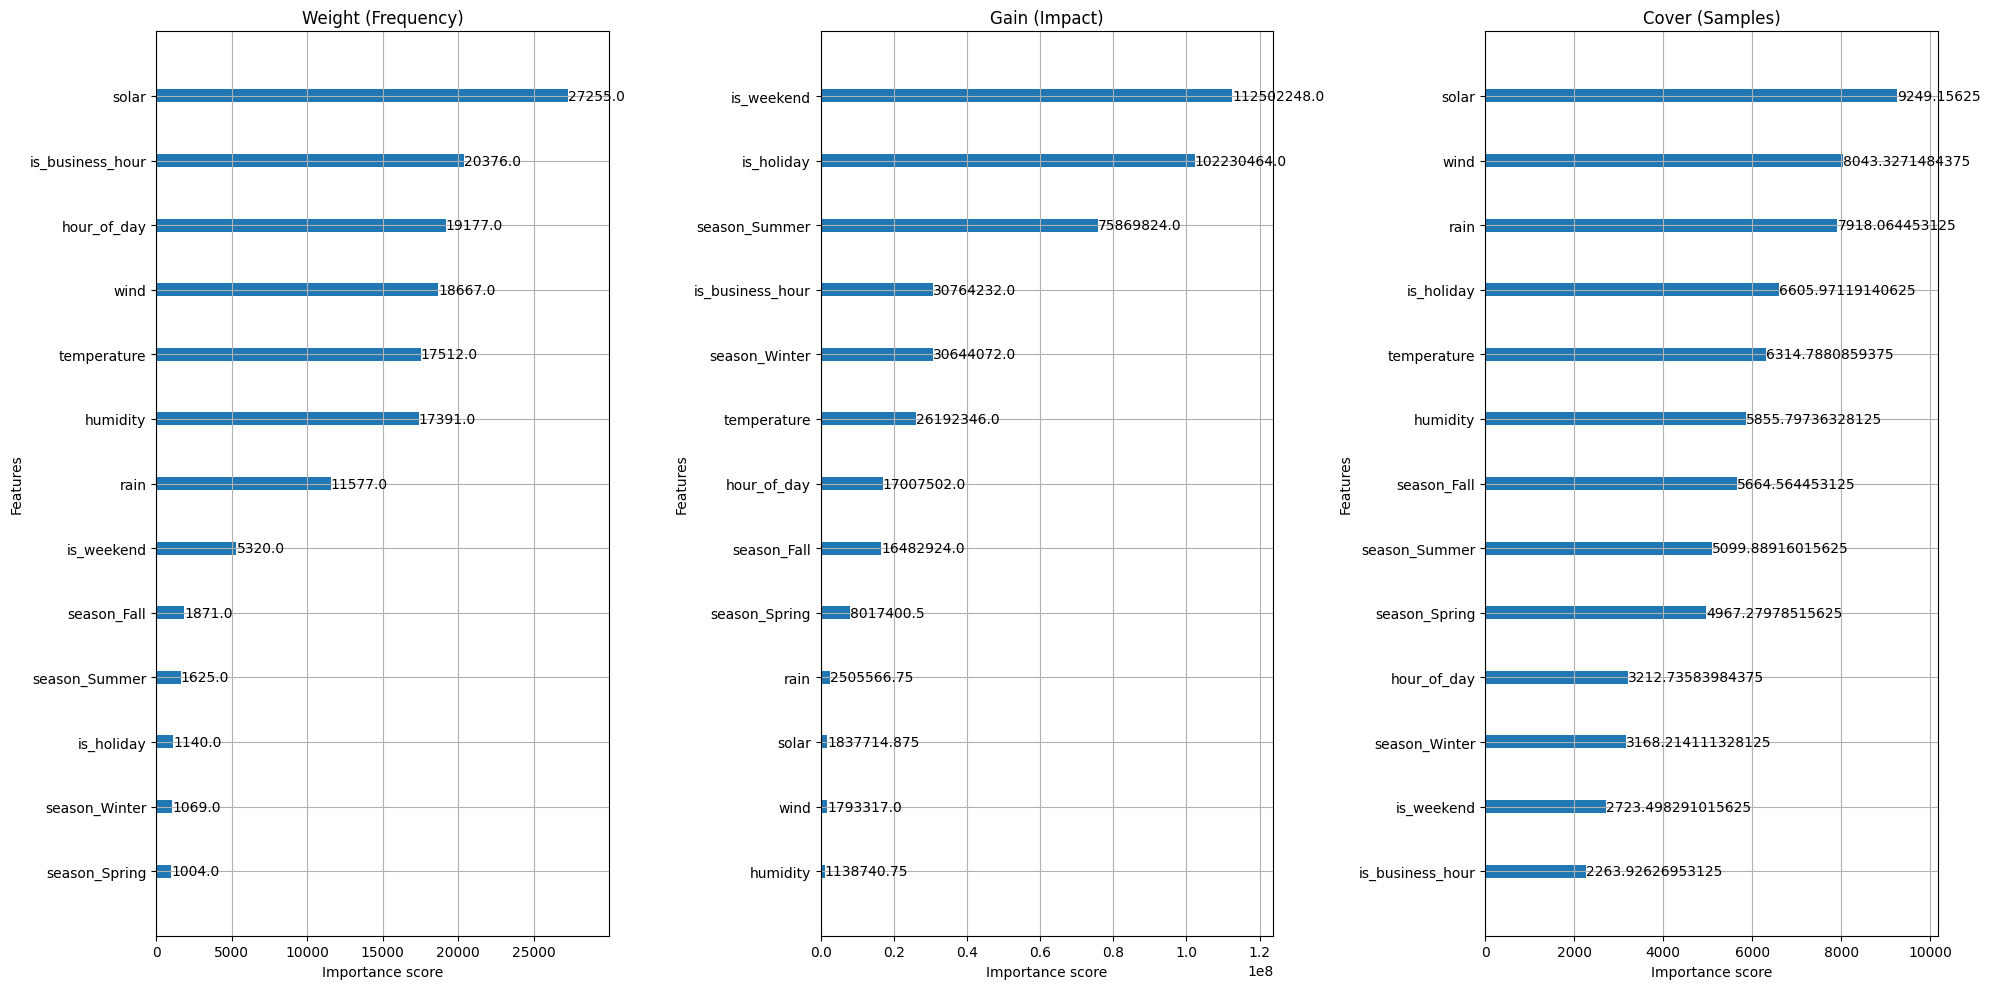

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import os
# --- Step 1: Load and Prepare Data ---
# Load the data from the CSV file.
try:
    df = pd.read_csv('z_attempt18//Building_A.csv')
except FileNotFoundError:
    print("Error: Building_A.csv not found in folder.")
    exit()

# --- Step 2: Feature Selection and Data Splitting ---
# For this example, we'll focus on CHR-01
target = 'Total_Cooling_Load'

# One-hot encode the 'season' column
df = pd.get_dummies(df, columns=['season'])
season_columns = [col for col in df.columns if col.startswith('season_')]

features = ['hour_of_day', 'is_weekend', 'is_business_hour','is_holiday','temperature','humidity', 'rain', 'wind', 'solar']
features = features + season_columns

# Check if all required columns are present
required_columns = features + [target]
if not all(col in df.columns for col in required_columns):
    print(f"Error: Not all required columns are in the dataframe.")
    exit()

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

evals = [(dtrain, 'train'), (dval, 'val')]
# --- Step 3: Train the Model ---

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 4,           # Much shallower trees
    'learning_rate': 0.01,    # Moderate learning rate
    'min_child_weight' : 5,
    'subsample': 0.8,         # Randomly sample 80% of data for each tree
    'colsample_bytree': 0.8,  # Randomly sample 80% of features for each tree
    'reg_alpha' : 1,
    'reg_lambda': 10,          # L2 regularization
}

model_a = xgb.train(
    params,
    dtrain,
    num_boost_round=10000,  # Set a very high number
    evals=evals,
    early_stopping_rounds=50, # Stop after 50 rounds without improvement on VALIDATION set
    verbose_eval=50
)
# Create a figure with 1 row and 3 columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

# Plot the three types of importance on each axis
xgb.plot_importance(model_a, importance_type='weight', ax=ax1, title='Weight (Frequency)')
xgb.plot_importance(model_a, importance_type='gain', ax=ax2, title='Gain (Impact)')
xgb.plot_importance(model_a, importance_type='cover', ax=ax3, title='Cover (Samples)')

plt.tight_layout()
plt.show()

Evident from the above importance charts, all weather features , i.e. `humidity`, `solar`, `wind`, `rain`, `temperature` , had weight and cover scores but low gain scores. Hence, the decision to remove them.

This highlights the importance of a systematic approach to feature selection and the need to be skeptical of features that seem intuitively important but do not improve the model's performance.

## Attempts 23, 24 Temperature lag

Attempt to introduce lag weather feature on the premise that **it takes time for a building to heat up** , which is confirmed by the charts as well.

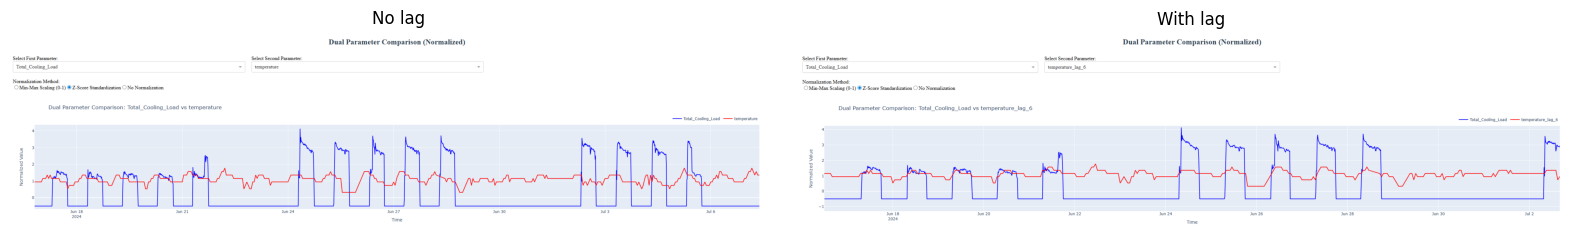

In [14]:
#@title Attempt 23,24 : 'temperature_lag'
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
# Create sample images or load your own
image1 = mpimg.imread('images\\temp-vs-q.png')  # Replace with your first image
image2 = mpimg.imread('images\\templag-vs-q.png')  # Replace with your second image

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Display first image
axes[0].imshow(image1, cmap='gray')
axes[0].set_title('No lag')
axes[0].axis('off')  # Remove axes

# Display second image
axes[1].imshow(image2, cmap='gray')
axes[1].set_title('With lag')
axes[1].axis('off')  # Remove axes

plt.tight_layout()
plt.show()

However, it did not yield an improvement in the model. It might make more sense to use a delta temperature (Indoor - outdoor) instead of a absolute outdoor temperature.

## Conclusion

The final model was trained exclusively on temporal features (e.g., 'hour_of_day', 'season', 'is_business_hour', 'is_workday','is_weekend', 'is_holiday') after exploratory analysis revealed that including raw weather data without corresponding building-specific parameters degraded predictive performance. This outcome underscores a critical insight: cooling load is not driven by external weather in isolation, but by the **interaction** between external conditions and the building's internal state and systems.

What other key datasets could improve the model. 
- Live chiller operating state.
While we were given chiller power consumption, flow rates, and supply/return temperatures, we were not able to fully utilise these training data since it was not available in the test set, which could be the key to predicting more accurate cooling loads.

- Indoor temperature/ setpoints, occupancy levels.
To create relationships between a building cooling load and environmental factors, we need to anchor these to meaningful features, i.e. heat gain through building envelope, or by building occupants/ users. The above attempts to introduce weather data without relationships reiterates this point. 

In summary, while a model based on time patterns provides a baseline, accurate cooling load prediction is fundamentally a physics-informed problem that requires data reflecting the building's internal response to external conditions.